<a href="https://colab.research.google.com/github/vivivicdjdk/machine/blob/main/8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망을 사용한 이미지 분류

**완전 연결 신경망 vs 합성곱 신경망**

완전 연결 신경망에서는 입력 이미즈를 밀집층에 연결하기 위해 일렬로 펼쳐야 했으나

합성곱 신경망에서는 2차원이미지를 그대로 이용하므로 펼치지 않음

다만 입력 이미지는 항상 깊이(채널)가 있어야 하므로 채널 차원을 추가함

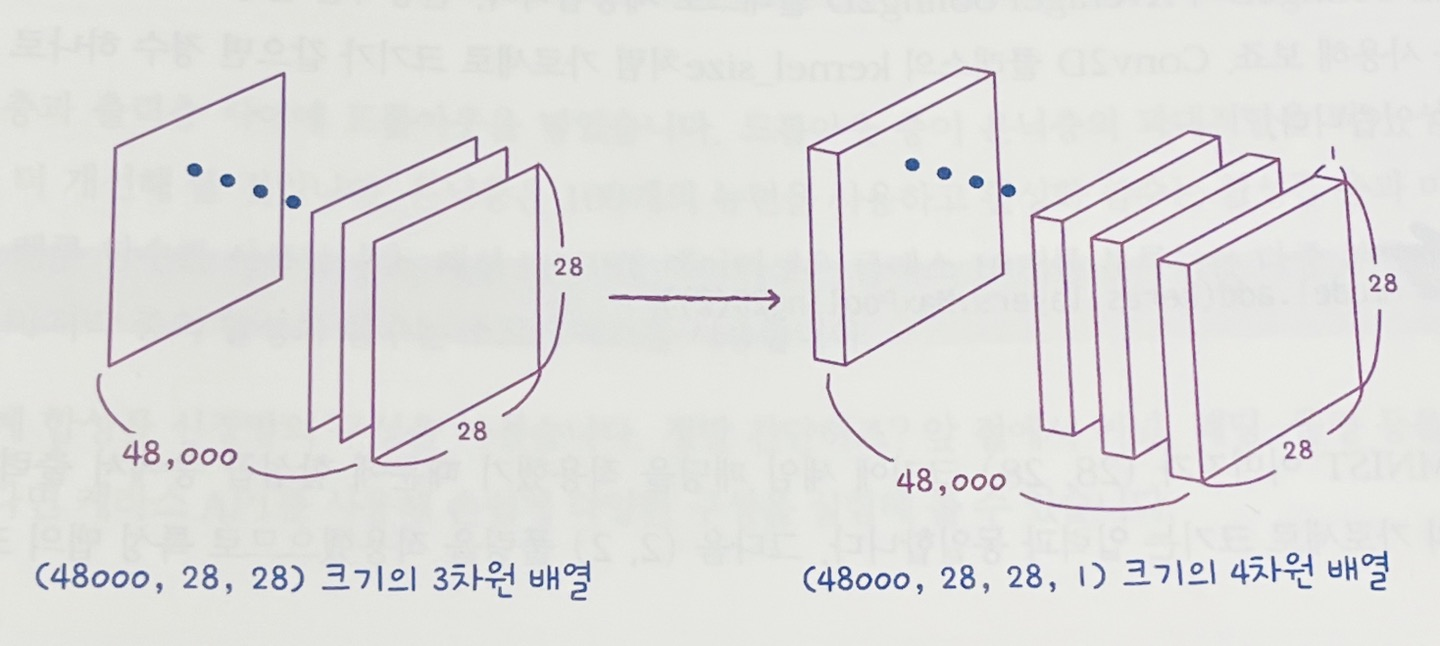

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
#(48000, 28, 28) -> (48000, 28, 28, 1)로 변경
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

**합성곱 신경망 만들기**

In [ ]:
model = keras.Sequential()

첫 번째 합성곱 층

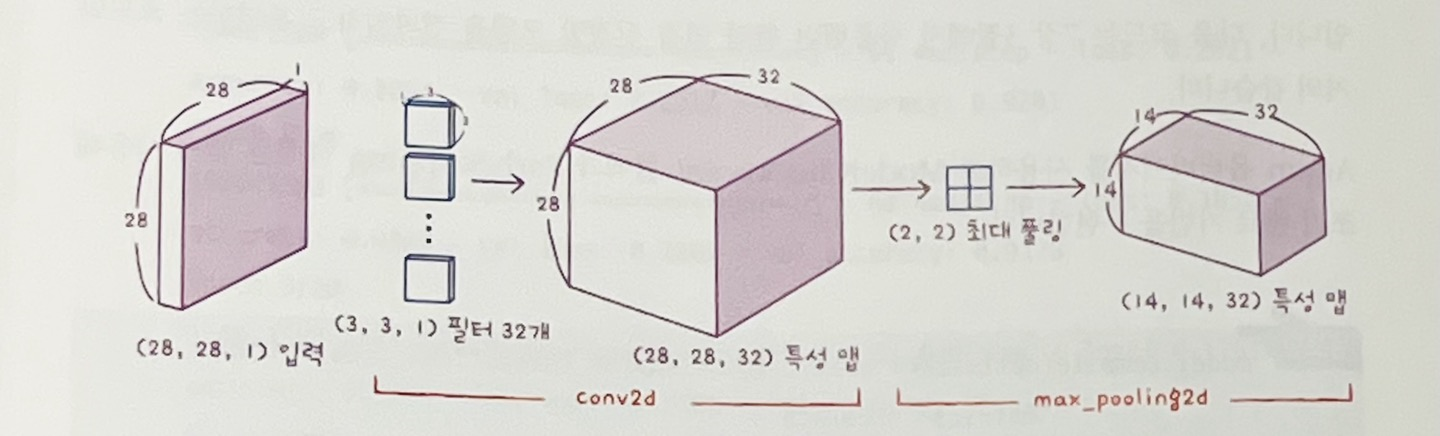

In [ ]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
model.add(keras.layers.MaxPooling2D(2))

두 번째 합성곱 층 + 완전 연결 층

과대적합을 막기 위해 드롭아웃을 추가

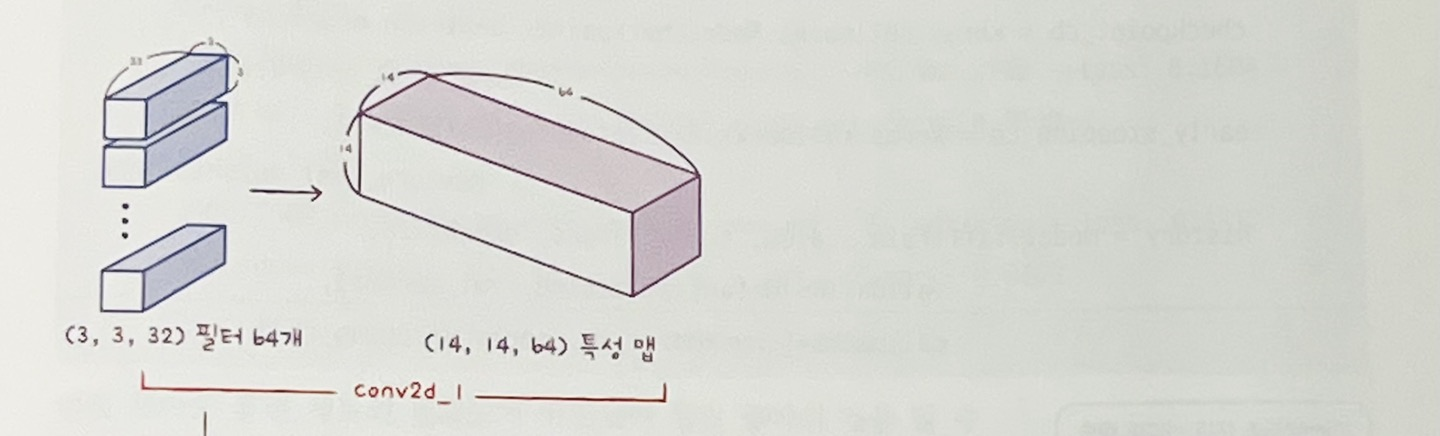

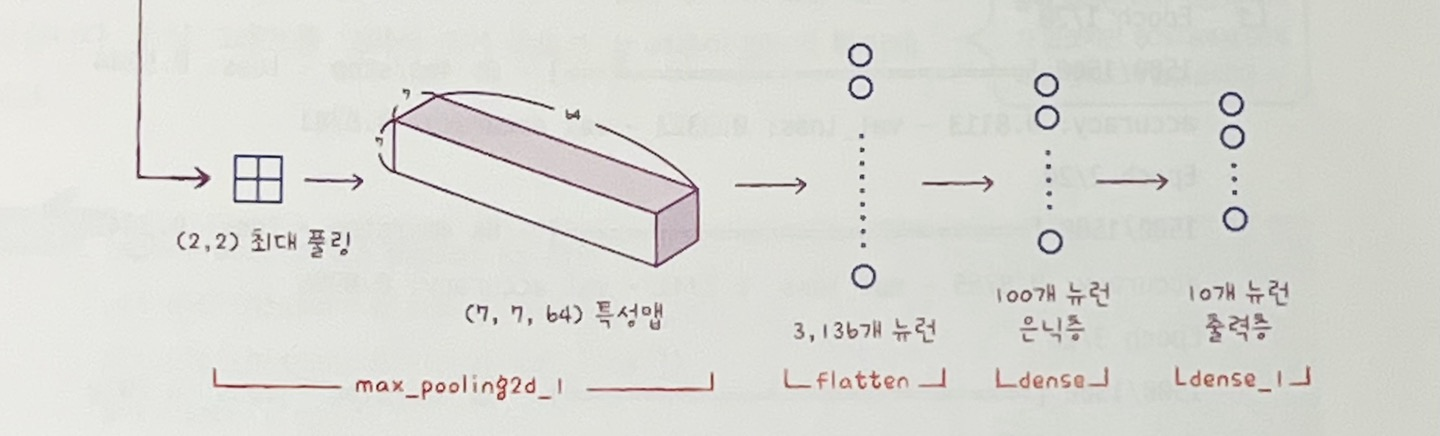

In [ ]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten()) # 3차원 특성맵을 일렬로 펼침
model.add(keras.layers.Dense(100, activation='relu')) # 밀집 은닉층 추가
model.add(keras.layers.Dropout(0.4)) # 드롭아웃을 추가하여 과대적합 방지
model.add(keras.layers.Dense(10, activation='softmax')) # 10개의 뉴런을 가진 (밀집)출력층에서 확률을 계산
model.summary()                 # 다중분류이므로 활성화함수는 softmax

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

**모델 파라미터 수를 계산해보자**

첫 번째 합성곱 층은 (3,3,1)크기의 32개의 필터를 가지고 있음. 필터마다 하나의 절편이 추가됨

따라서 3 * 3 * 1 * 32 + 32 = 320

두 번째 합성곱 층은(3,3,32)크기의 64개의 필터를 가지고 있음. 필터마다 하나의 절편이 추가됨

따라서 3 * 3 * 32 * 64 + 64 = 18496

Flatten 층에서 (7,7,64)크기의 특성 맵을 1차원 배열로 펼치면 7 * 7 * 64 = 3136 크기의 배열이 됨

이를 100개의 뉴런과 완전히 연결해야 하므로 은닉층의 모데 파라미터 개수는 3136 * 100 + 100 = 313700

마지막 출력층은 100 * 10 + 10 = 1010


**층의 구성을 그림으로 표현해보자**

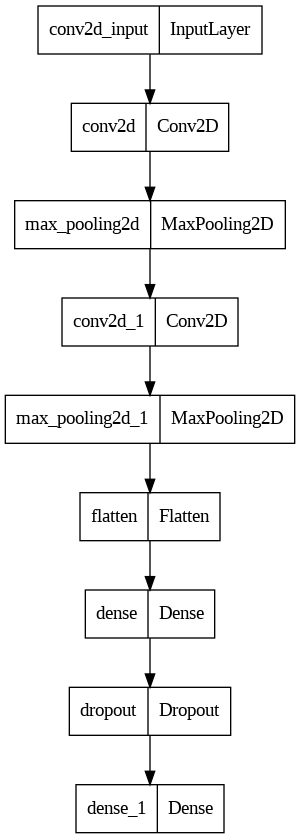

In [ ]:
keras.utils.plot_model(model)

      # 층의 이름 : 클래스

입력과 출력의 크기도 같이 표현해보자

show_shapes 매개변수를 True로 지정

to_file 매개변수에 파일 이름을 지정하면 출력된 이미지를 파일로 저장함

기본값으로 to_file='model.png'로 지정되어있음

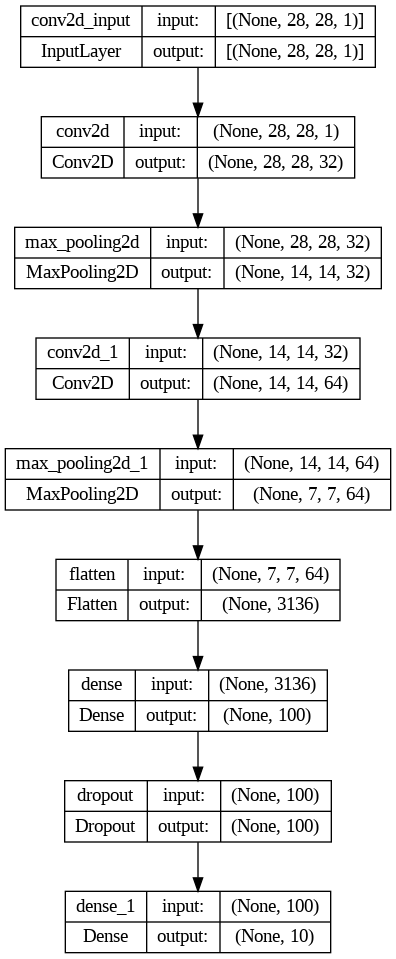

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

##모델 컴파일과 훈련

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 10s 5ms/step - loss: 0.1396 - accuracy: 0.9480 - val_loss: 0.2280 - val_accuracy: 0.9234
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1614 - accuracy: 0.9389 - val_loss: 0.2289 - val_accuracy: 0.9203
Epoch 3/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1460 - accuracy: 0.9457 - val_loss: 0.2218 - val_accuracy: 0.9293
Epoch 4/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1320 - accuracy: 0.9506 - val_loss: 0.2158 - val_accuracy: 0.9263
Epoch 5/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1231 - accuracy: 0.9530 - val_loss: 0.2323 - val_accuracy: 0.9256
Epoch 6/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1137 - accuracy: 0.9574 - val_loss: 0.2311 - val_accuracy: 0.9277


케라스 API는 딥러닝 모델의 종류나 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 장점을 가짐

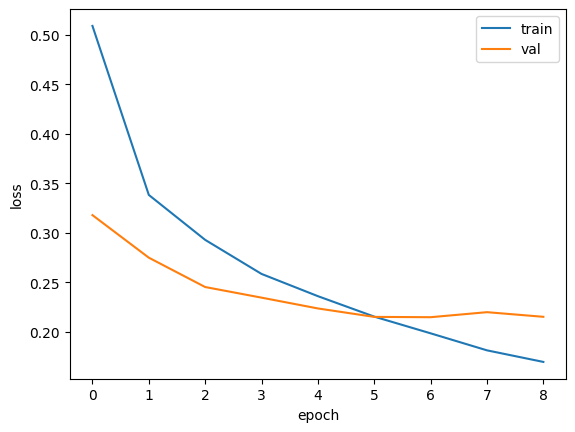

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

earlyStopping클래스에서 restore_best_weights 매개변수를 true로 지정했기 때문에 현재 model 객체에 가장 최적의 모델 파라미터로 복원되어있음

즉, modelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없음

In [ ]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2145 - accuracy: 0.9202


[0.21453545987606049, 0.9201666712760925]

첫 번째 검증 데이터를 확인해보자

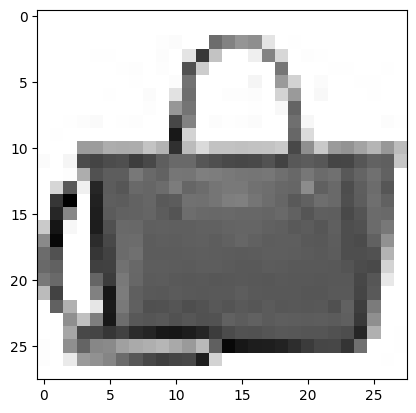

In [ ]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

첫 번째 검증 데이터를 예측해보자



In [ ]:
preds = model.predict(val_scaled[0:1])
print(preds) #100퍼센트 확률로 9번째

1/1 [==============================] - 0s 115ms/step
[[3.3830289e-14 1.6479672e-22 2.1887265e-18 1.7189894e-15 6.0608955e-14
  2.9962747e-12 7.4386124e-13 8.6856405e-14 1.0000000e+00 1.9710426e-14]]


**슬라이싱 한 이유**

predict() 메서드에 데이터를 전달할 때 val_scaled[0]가 아닌 val_scaled[0:1]와 같이 슬라이싱함

그 이유는 케라스의 fit(), predict(), evaluate()메서드는 모두 입력의 첫 번째 차원이 배치 차원으로 생각하기 때문임

따라서 샘플 하나를 전달할 때는 (28,28,1)이 아니라 (1,28,28,1)크기를 전달해야함

배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1,28,28,1)크기를 만듦

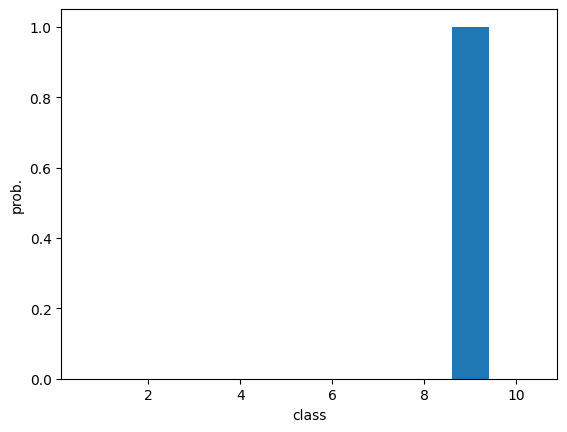

In [ ]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [ ]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']
import numpy as np
print(classes[np.argmax(preds)])

가방


테스트 샘플에 대한 예측을 수행해보자

In [ ]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0 # 테스트 형태와 훈련했던 형태가 같아야함
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2394 - accuracy: 0.9141


[0.23940542340278625, 0.9140999913215637]